# Find percentiles 

Notebook determines SST percentiles for the tropical Pacific from the years 1982--2020 for observational products and CMIP5/6 data.

CMIP5/6 data is stored in DataTree structures see https://xarray-datatree.readthedocs.io/en/latest/ 

To note: recently datatree has merged with xarray, currently some functunality has been lost.

This code was run on Gadi supercomupter, calculations were completed and datasets saved so that plots could be performed locally.

In [2]:
# load packges
import numpy as np
import pandas as pd
import math
import calendar
from scipy.stats import norm

# xarray 
import xarray as xr
from xarray import DataTree
import dask
from xhistogram.xarray import histogram
import xskillscore as xs

# plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib.lines import Line2D
import seaborn as sns
import cartopy.crs as ccrs
from xarrayutils.plotting import shaded_line_plot


In [4]:
# Gridded data of CMIP5/6 data of tropics lat(-20,20) 1982-2020, datatree with 13 models and multiple ensemble members 
# change directory to collated datatree
dt_tropics = xr.open_datatree('/g/data/e14/ic0706/Project_1/timeseries/Gridded_Data/dt_cmip_198201-202001_trop_g025.nc')
dt_tropics

In [8]:
models =['CESM1-CAM5',
 'CanESM2',
 'GFDL-ESM2M',
 'MPI-ESM',
 'ACCESS-ESM1-5',
 'CanESM5',
 'EC-Earth3',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-LR',
 'CESM2',
 'GFDL-SPEAR-MED']


data_tree=dt_tropics

mods = {}
for model_name, model_data in data_tree.items():
    en=[]
    for ensemble_name, ensemble_data in data_tree[model_name].items():
        en.extend([str(ensemble_name)])
    
    mods[str(model_name)]=en

## Functions used 

#### quantiles_xhist(data)

input: dataset with a variable tos - if different change function

output: dataarray of percentiles with same timeframe and areas of 0.005 scale


#### quantile_datatree(datatree, sources)

input: datatree of the form 


models

  |
  
  --------- ensemble members
  
                 |
                 
                 ------------ datasets with tos 

In [9]:
# define function to calculate percentiles
def quantiles_xhist(data):
    hist_T = data.tos.squeeze()
    weights = np.cos(np.deg2rad(hist_T.lat))
    times = hist_T['time']
    const_area=np.r_[0:1:0.01]
    temps = np.r_[12:34:0.5] # define temperatures for binning 
    
    temps_interp = np.empty([len(times),len(const_area)])
    
    for i in np.r_[0:len(times):1]:  
        h=histogram(hist_T[i],bins=temps,weights=weights).cumsum()
        hh = (h - h[0])/(h[-1]-h[0])
        temps_interp[i]=np.interp(const_area,hh,temps[1:])
    
    
    sst_area= xr.DataArray(temps_interp,coords={'time':times,'area':const_area})

    return(sst_area)

# find percentiles for each model - atm one run per model
def quantile_datatree(datatree,sources):
    q ={}
    for i in range(len(sources)):
        q[i] = quantiles_xhist(datatree[sources[i]])

    quantiles = DataTree.from_dict({sources[i]:q[i].rename('temp') for i in range(len(sources))})
    return(quantiles)

# Gridded tropical pacific dataset

In [9]:
# mask for tropical Pacific
# Code block adapted from Taimoor Sohail
sst =dt_tropics['ACCESS-ESM1-5/r39i1p1f1'].tos # temperature grid to choose, all CMIP5/6 models have same grid
LonsPts_pos = [130,120,110,110,110,260,270,270,277,291,291,130] #-np.ones(13)*180
LatsPts_pos =[-20,-10,-5,10,20,20,15,15,10,5,-20,-20]

x_pixel_pos = LonsPts_pos
y_pixel_pos = LatsPts_pos

temp_list = []
for a, b in zip(x_pixel_pos, y_pixel_pos):
    temp_list.append([a, b])

polygon = np.array(temp_list)
xv, yv = sst.lon.values, sst.lat.values
lon2d, lat2d = np.meshgrid(xv, yv)
points = np.hstack((lon2d.reshape((-1,1)), lat2d.reshape((-1,1))))
path = matplotlib.path.Path(polygon)
mask = path.contains_points(points)
mask.shape = lon2d.shape
mask_bit_pos = mask*np.ones_like(lon2d)
mask_mods = mask_bit_pos
mask_mods[mask_mods==0] = np.nan

dt_pacific = dt_tropics*mask_mods
# change to a local directory
dt_pacific.to_netcdf('/g/data/e14/ic0706/Project_1/timeseries/Gridded_Data/dt_cmip_198201-202001_trop_pacific_g025.nc')

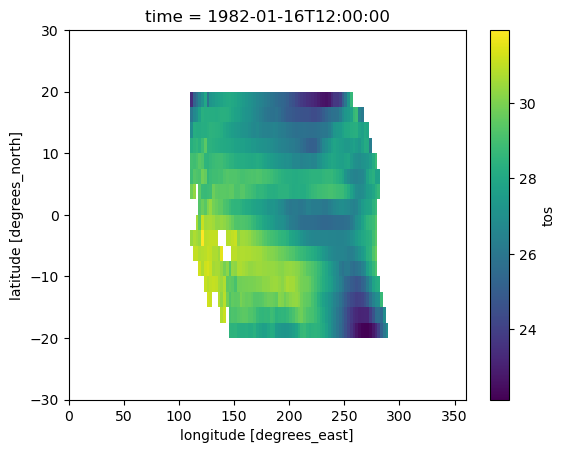

In [11]:
# check mask
dt_pacific['ACCESS-ESM1-5/r39i1p1f1'].tos.isel(time=0).plot()

## Determine multi model mean sst

In [12]:

# List of desired dimensions
desired_dims = ['time', 'lat', 'lon']

# Function to drop extra dimensions
def drop_extra_dims(array, desired_dims):
    # Select only the desired dimensions
    selected_array = array
    for dim in array.dims:
        if dim not in desired_dims:
            selected_array = selected_array.squeeze(dim=dim)
    return selected_array

mods_avg = {}
avg_all = 0
for model in models:
    avg=0
    for i in range(len(mods[model])):
        to_add = drop_extra_dims(dt_tropics[model][mods[model][i]].tos, desired_dims)
        avg += to_add
    mods_avg[model]  = avg/len(mods[model])
    avg_all +=mods_avg[model].values

mmm = dt_tropics['ACCESS-ESM1-5'][mods['ACCESS-ESM1-5'][0]].tos.copy()
mmm.data= avg_all / len(models)
# mmm.to_netcdf('local_directory/mmm_trop_pacific.nc')

In [16]:
# determine SST percentiles for multi model mean
hist_data = mmm.mean(dim='time')
weights = np.cos(np.deg2rad(hist_data.lat))
const_area=np.r_[0:1:0.01]
temps = np.r_[12:34:0.5] # define temperatures for binning 

h=histogram(hist_data,bins=temps,weights=weights).cumsum()
hh = (h - h[0])/(h[-1]-h[0])
temps_interp=np.interp(const_area,hh,temps[1:])

mmm_percentiles = xr.DataArray(temps_interp, coords ={'area':const_area})

In [18]:
# save gridded multi model mean data and percentile data
mmm_percentiles.to_netcdf('/g/data/e14/ic0706/Project_1/timeseries/percentiles/cmip_mmm_1982_2020_time_avg_percentiles.nc')
hist_data.to_netcdf('/g/data/e14/ic0706/Project_1/timeseries/Gridded_Data/cmip_mmm_1982_2020_time_avg_g025.nc')

## Observational Products

In [35]:
obs = xr.open_dataset('~/Project_1/data/sst.mon.ltm.nc')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:525: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


<xarray.Dataset> Size: 2MB
Dimensions:             (lat: 89, lon: 180, time: 12, nbnds: 2)
Coordinates:
  * lat                 (lat) float32 356B 88.0 86.0 84.0 ... -84.0 -86.0 -88.0
  * lon                 (lon) float32 720B 0.0 2.0 4.0 6.0 ... 354.0 356.0 358.0
  * time                (time) object 96B 0001-01-01 00:00:00 ... 0001-12-01 ...
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) datetime64[ns] 192B ...
    sst                 (time, lat, lon) float32 769kB ...
    valid_yr_count      (time, lat, lon) float32 769kB ...
Attributes: (12/38)
    climatology:                    Climatology is based on 1971-2000 SST, Xu...
    description:                    In situ data: ICOADS2.5 before 2007 and N...
    keywords_vocabulary:            NASA Global Change Master Directory (GCMD...
    keywords:                       Earth Science > Oceans > Ocean Temperatur...
    instrument:                     Conventional thermometers
    source_comment:                 SSTs were observed by conventional thermo...
    ...                             ...
    license:                        No constraints on data access or use
    comment:                        SSTs were observed by conventional thermo...
    summary:                        ERSST.v5 is developed based on v4 after r...
    dataset_title:                  NOAA Extended Reconstructed SST V5
    data_modified:                  2021-02-07
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...

## Find percentiles of tropical Pacific

In [14]:

## pacific  

cmip_percentiles_lat20 = DataTree(name='Models')
data =dt_pacific.sel(lat=slice(-20,20))
ds={}
for m in range(len(models)):
    print(models[m])
    ds[m] = quantile_datatree(data[models[m]],mods[models[m]][0:len(mods[models[m]])])

cmip_percentiles_lat20.children = {models[i]:ds[i] for i in range(len(models))}
del ds
del data

print('percentiles ma lat=(-20,20) done')
cmip_percentiles_lat20.to_netcdf('/g/data/e14/ic0706/Project_1/timeseries/percentiles/dt_percentile_cmip_pacific_198201-202001_lat20.nc')
print('saved')


CESM1-CAM5
CanESM2
GFDL-ESM2M
MPI-ESM
ACCESS-ESM1-5
IPSL-CM6A-LR
MIROC-ES2L
MIROC6
MPI-ESM1-2-LR
CESM2
GFDL-SPEAR-MED
percentiles ma lat=(-20,20) done
saved


# Find average of the warmest and coldest 50% for each model mean and mean state for each gridded dataset sst map for each model 

In [2]:
# Load dataset if above code is not run
# cmip_percentiles_lat20= datatree.open_datatree('/g/data/e14/ic0706/Project_1/timeseries/percentiles/dt_percentile_cmip_pacific_198201-202001_lat20.nc')

0.3.0


In [9]:
model_mean={}
for m in range(len(models)):
    x=0
    sources = mods[models[m]][0:len(mods[models[m]])]
    for i in range(len(sources)):
        x = x+ cmip_percentiles_lat20[models[m]+'/'+sources[i]]
    model_mean[m]=x/len(sources)
    
    del x

area=[]
for i in range(len(models)):
    area.append(model_mean[i].sel(area=0.5).mean().temp.values)

In [40]:
# load gridded tropics dataset
dt_tropics['ACCESS-ESM1-5/r39i1p1f1'].lat.values

DataTree('None', parent=None)
├── DataTree('ACCESS-ESM1-5')
│   ├── DataTree('r39i1p1f1')
│   │       Dimensions:  (time: 468, lon: 144, lat: 24)
│   │       Coordinates:
│   │         * time     (time) datetime64[ns] 1982-01-16T12:00:00 ... 2020-12-16T12:00:00
│   │         * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
│   │         * lat      (lat) float64 -28.75 -26.25 -23.75 -21.25 ... 23.75 26.25 28.75
│   │       Data variables:
│   │           tos      (time, lat, lon) float64 ...
│   ├── DataTree('r36i1p1f1')
│   │       Dimensions:  (time: 468, lon: 144, lat: 24)
│   │       Coordinates:
│   │         * time     (time) datetime64[ns] 1982-01-16T12:00:00 ... 2020-12-16T12:00:00
│   │         * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
│   │         * lat      (lat) float64 -28.75 -26.25 -23.75 -21.25 ... 23.75 26.25 28.75
│   │       Data variables:
│   │           tos      (time, lat, lon) float64 ...
│   ├── DataTree('r12i1p1f1')
│   │       Dimensions:  (time: 468, lon: 144, lat: 24)
│   │       Coordinates:
│   │         * time     (time) datetime64[ns] 1982-01-16T12:00:00 ... 2020-12-16T12:00:00
│   │         * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
│   │         * lat      (lat) float64 -28.75 -26.25 -23.75 -21.25 ... 23.75 26.25 28.75
│   │       Data variables:
│   │           tos      (time, lat, lon) float64 ...
│   ├── DataTree('r6i1p1f1')
│   │       Dimensions:  (time: 468, lon: 144, lat: 24)
│   │       Coordinates:
│   │         * time     (time) datetime64[ns] 1982-01-16T12:00:00 ... 2020-12-16T12:00:00
│   │         * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
│   │         * lat      (lat) float64 -28.75 -26.25 -23.75 -21.25 ... 23.75 26.25 28.75
│   │       Data variables:
│   │           tos      (time, lat, lon) float64 ...
│   ├── DataTree('r28i1p1f1')
│   │       Dimensions:  (time: 468, lon: 144, lat: 24)
│   │       Coordinates:
│   │         * time     (time) datetime64[ns] 1982-01-16T12:00:00 ... 2020-12-16T12:00:00
│   │         * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
│   │         * lat      (lat) float64 -28.75 -26.25 -23.75 -21.25 ... 23.75 26.25 28.75
│   │       Data variables:
│   │           tos      (time, lat, lon) float64 ...
│   ├── DataTree('r35i1p1f1')
│   │       Dimensions:  (time: 468, lon: 144, lat: 24)
│   │       Coordinates:
│   │         * time     (time) datetime64[ns] 1982-01-16T12:00:00 ... 2020-12-16T12:00:00
│   │         * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
│   │         * lat      (lat) float64 -28.75 -26.25 -23.75 -21.25 ... 23.75 26.25 28.75
│   │       Data variables:
│   │           tos      (time, lat, lon) float64 ...
│   ├── DataTree('r14i1p1f1')
│   │       Dimensions:  (time: 468, lon: 144, lat: 24)
│   │       Coordinates:
│   │         * time     (time) datetime64[ns] 1982-01-16T12:00:00 ... 2020-12-16T12:00:00
│   │         * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
│   │         * lat      (lat) float64 -28.75 -26.25 -23.75 -21.25 ... 23.75 26.25 28.75
│   │       Data variables:
│   │           tos      (time, lat, lon) float64 ...
│   ├── DataTree('r32i1p1f1')
│   │       Dimensions:  (time: 468, lon: 144, lat: 24)
│   │       Coordinates:
│   │         * time     (time) datetime64[ns] 1982-01-16T12:00:00 ... 2020-12-16T12:00:00
│   │         * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
│   │         * lat      (lat) float64 -28.75 -26.25 -23.75 -21.25 ... 23.75 26.25 28.75
│   │       Data variables:
│   │           tos      (time, lat, lon) float64 ...
│   ├── DataTree('r37i1p1f1')
│   │       Dimensions:  (time: 468, lon: 144, lat: 24)
│   │       Coordinates:
│   │         * time     (time) datetime64[ns] 1982-01-16T12:00:00 ... 2020-12-16T12:00:00
│   │      

In [61]:
lats = dt_tropics['ACCESS-ESM1-5/r39i1p1f1'].lat.values
lons = dt_tropics['ACCESS-ESM1-5/r39i1p1f1'].lon.values
model_mean=np.empty((len(models),len(lats),len(lons)))
# model_mean={}
for m in range(len(models)):
    x=0
    sources = mods[models[m]][0:len(mods[models[m]])]
    for i in range(len(sources)):
        x = x+ dt_tropics[models[m]+'/'+sources[i]]
    model_mean[m,:,:] = (x/len(sources)).tos.mean(dim='time').values
    
    del x

In [63]:
# avg.to_netcdf('/g/data/e14/ic0706/Project_1/timeseries/Gridded_Data/da_cmip_avg_sst_pacific_lat20.nc')
